In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm, trange

import torch
from haloflow import data as D
from haloflow import util as U

In [2]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [3]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

## read $q_\phi(Y\,|\,X)$

184 models trained
[167, 60, 32, 114, 115]
113 models trained
[106, 1, 109, 48, 53]
85 models trained
[1, 36, 61, 29, 60]
134 models trained
[116, 107, 49, 58, 125]
95 models trained
[43, 31, 55, 72, 22]
207 models trained
[129, 150, 107, 77, 113]
89 models trained
[22, 23, 5, 58, 59]
79 models trained
[34, 37, 54, 31, 32]
55 models trained
[31, 38, 33, 51, 20]
42 models trained
[27, 31, 30, 33, 9]


Text(0.5, 0, 'true $\\log M_h$')

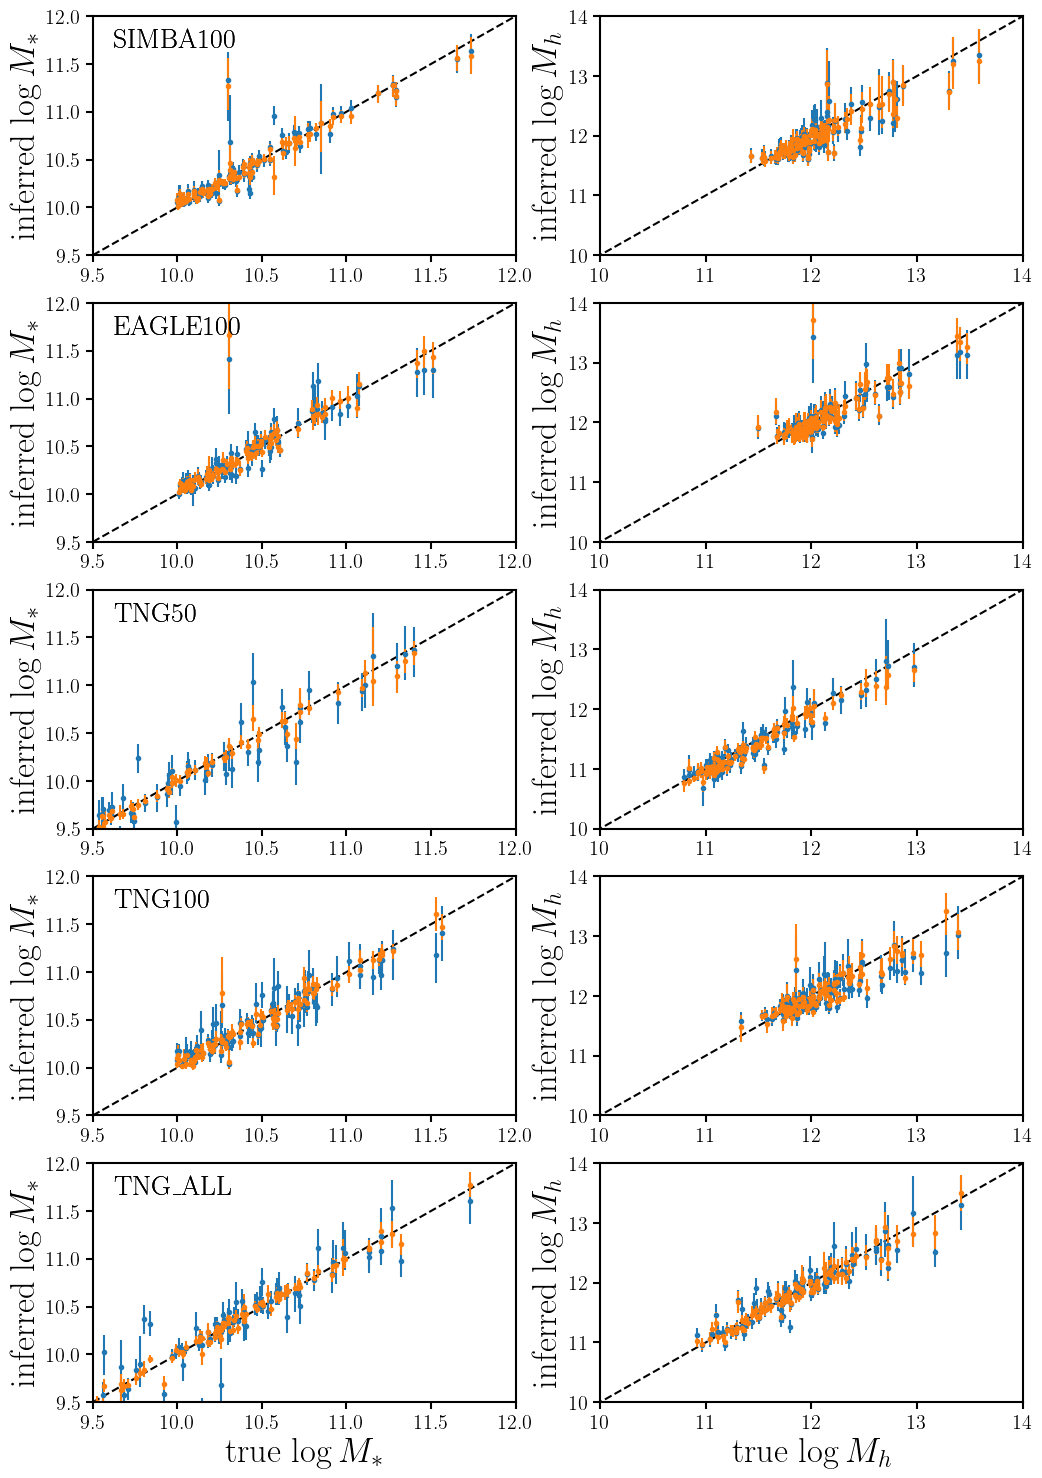

In [6]:
fig = plt.figure(figsize=(12,18))

for i_sim, sim in enumerate(['Simba100', 'Eagle100', 'TNG50', 'TNG100', 'TNG_ALL']): 
    # plot 
    sub0 = fig.add_subplot(5,2,2*i_sim+1)
    sub0.plot([9.5, 12.], [9.5, 12.], c='k', ls='--')
    
    sub1 = fig.add_subplot(5,2,2*i_sim+2)
    sub1.plot([9.5, 14.], [9.5, 14.], c='k', ls='--')

    # test-data
    Y_test, _ = D.hf2_centrals('test', 'mags_morph', sim=sim)

    igals = np.random.choice(np.arange(Y_test.shape[0]), size=100, replace=False)
    y_true = Y_test[igals]
    
    for i_obs, obs in enumerate(['mags', 'mags_morph']): 
        # read q_phis
        qphis = U.read_best_ndes('h2.v1.%s.%s' % (sim, obs), n_ensemble=5, device=device, 
                             dat_dir='/scratch/gpfs/chhahn/haloflow/hf2/npe', verbose=True)
        Y_test, X_test = D.hf2_centrals('test', obs, sim=sim)        

        # sample NDEs
        n_sample = 1000
        y_nde = [] 
        for i in igals: 
            y_samp = []
            for qphi in qphis: 
                _samp = qphi.sample((int(n_sample/len(qphis)),),
                                       x=torch.tensor(X_test[i], dtype=torch.float32).to(device), 
                                       show_progress_bars=False)
                y_samp.append(_samp.detach().cpu().numpy())
            y_nde.append(np.concatenate(np.array(y_samp), axis=0)) 
        y_nde = np.array(y_nde)
        y_nde_q0, y_nde_q1, y_nde_q2 = np.quantile(y_nde, (0.16, 0.5, 0.84), axis=1)
    
        # plot comparison
        sub0.text(0.05, 0.95, sim.upper(), transform=sub0.transAxes, ha='left', va='top', fontsize=20)
        sub0.errorbar(y_true[:,0], y_nde_q1[:,0], 
                     yerr=[y_nde_q1[:,0] - y_nde_q0[:,0], y_nde_q2[:,0] - y_nde_q1[:,0]], fmt='.C%i' % i_obs)
        sub1.errorbar(y_true[:,1]+0.05, y_nde_q1[:,1], 
                     yerr=[y_nde_q1[:,1] - y_nde_q0[:,1], y_nde_q2[:,1] - y_nde_q1[:,1]], fmt='.C%i' % i_obs)

    sub0.set_ylabel(r'inferred $\log M_*$', fontsize=25)
    sub0.set_xlim(9.5, 12.)
    sub0.set_ylim(9.5, 12.)
    
    sub1.set_ylabel(r'inferred $\log M_h$', fontsize=25)
    sub1.set_xlim(10., 14.)
    sub1.set_ylim(10., 14.)
    
sub0.set_xlabel(r'true $\log M_*$', fontsize=25)

sub1.set_xlabel(r'true $\log M_h$', fontsize=25)